In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# --- 1. Data Loading and Initial Inspection ---

# Load the data from the original CSV file
df = pd.read_csv('Medicaldataset.csv')

print("Initial Data Shape:", df.shape)
print("\nInitial Data Info:")
df.info()

Initial Data Shape: (1319, 9)

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [28]:
df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [29]:
df.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


In [30]:
df.isnull().sum()

Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

In [31]:
# --- 2. Target Encoding (Categorical to Numerical) ---

# Convert the categorical 'Result' column to numeric: positive=1 (Disease), negative=0 (Normal)
df['Result_Encoded'] = df['Result'].map({'positive': 1, 'negative': 0})
df = df.drop(columns=['Result'])

In [32]:
# --- 3. Outlier Handling (Removing 'Heart rate' == 1111) ---

# Identify and document rows with impossible 'Heart rate' value
heart_rate_col = 'Heart rate'
rows_to_remove = df[df[heart_rate_col].astype(str).str.contains('1111', na=False)]
removed_count = len(rows_to_remove)

# Remove the identified rows
df = df[~df[heart_rate_col].astype(str).str.contains('1111', na=False)]

# Convert all remaining columns to proper numeric types, coercing any unforeseen errors (should be 0)
numeric_cols = df.columns
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"\n✅ Data Cleaned: {removed_count} samples removed (Heart rate = 1111).")
print(f"Total remaining samples: {df.shape[0]}")

# Save the intermediate cleaned dataset
# df.to_csv('cleaned_medicaldataset.csv', index=False)


✅ Data Cleaned: 3 samples removed (Heart rate = 1111).
Total remaining samples: 1316


In [33]:
# --- 4. Target Distribution Visualization (Plotly) ---

target_distribution = df['Result_Encoded'].value_counts()
target_percentage = df['Result_Encoded'].value_counts(normalize=True) * 100

dist_df = pd.DataFrame({
    'Result': ['Positive (Disease)', 'Negative (Normal)'],
    'Count': target_distribution.values
})

fig = px.bar(
    dist_df, 
    x='Result', 
    y='Count', 
    title='Target Variable Distribution (Heart Attack Prediction)',
    color='Result',
    text='Count'
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title="Result (0: Negative, 1: Positive)")
fig.show()

# Store feature names for next steps
all_features = ['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']
continuous_features = ['Age', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']

# Feature Distribution Analysis (Histograms & Boxplots)

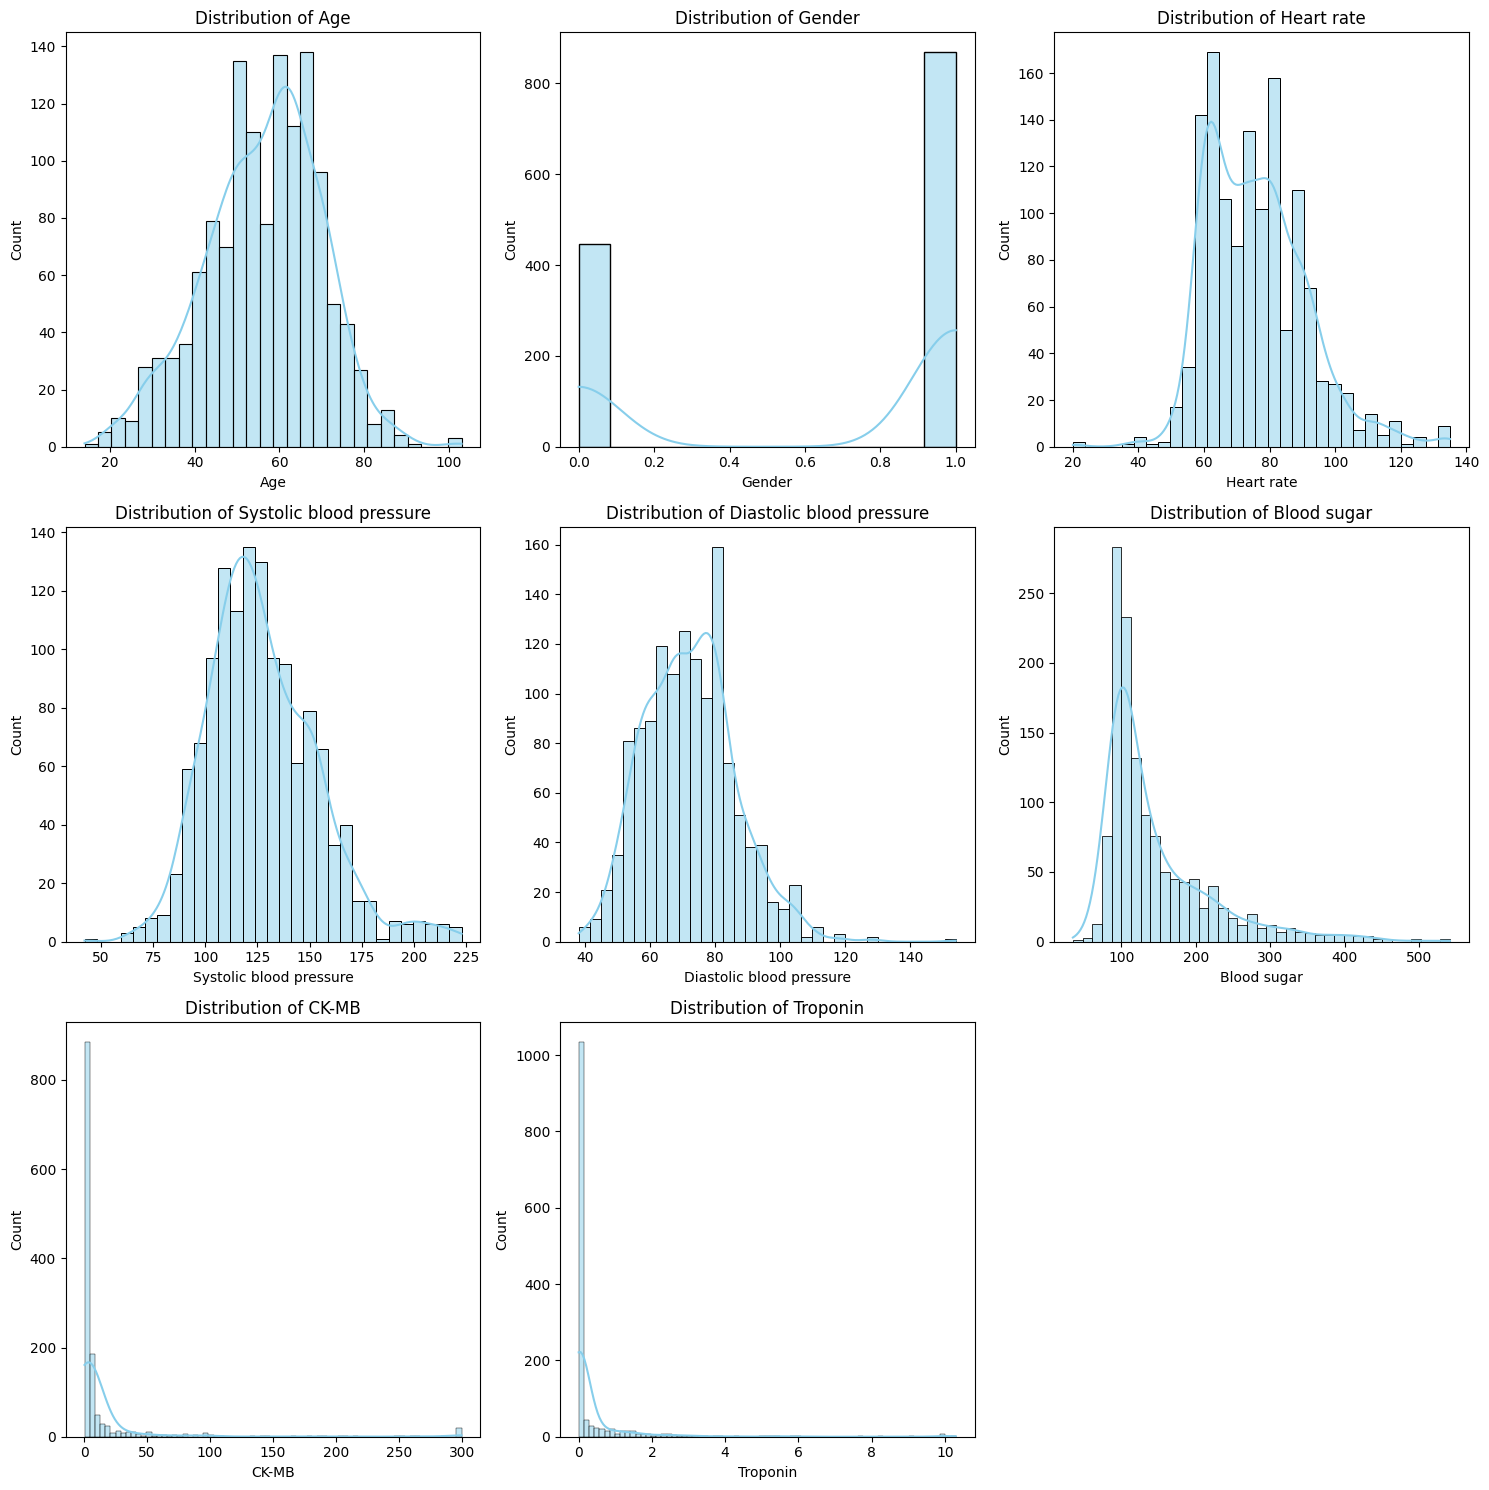

In [34]:
# --- DEFINE FEATURES AND CREATE MULTI-PLOT FIGURE ---

# Define the features to visualize
features = [
    'Age', 
    'Gender', 
    'Heart rate', 
    'Systolic blood pressure', 
    'Diastolic blood pressure', 
    'Blood sugar', 
    'CK-MB', 
    'Troponin'
]

n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols # Dynamically calculate rows needed

# Set the figure size and spacing
plt.figure(figsize=(15, 5 * n_rows))
plt.subplots_adjust(hspace=0.4)

# Loop through all features to create subplots
for i, feature in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Use histplot with KDE (Kernel Density Estimate) to mimic the smooth curve 
    # over the bars, similar to the style in the research paper.
    sns.histplot(df[feature], kde=True, ax=ax, bins='auto', color='skyblue')
    
    ax.set_title(f'Distribution of {feature}', fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# In a notebook, you would typically use plt.show()
plt.show()

In [35]:
# --- 1. Visualize Distributions for Continuous Features ---

for feature in continuous_features:
    # Histogram for Distribution
    fig_hist = px.histogram(
        df, 
        x=feature, 
        color='Result_Encoded', 
        marginal='box', 
        title=f'Distribution of {feature} by Result',
        labels={'Result_Encoded': 'Result (1=Pos, 0=Neg)'}
    )
    fig_hist.show()

    # Boxplot for Outlier Detection (Clearer view)
    fig_box = px.box(
        df, 
        y=feature, 
        color='Result_Encoded', 
        title=f'Boxplot of {feature} (Outlier Check)',
        labels={'Result_Encoded': 'Result (1=Pos, 0=Neg)'}
    )
    fig_box.show()

# --- 2. Visualize Discrete Feature (Gender) Distribution ---

fig_gender = px.histogram(
    df, 
    x='Gender', 
    color='Result_Encoded', 
    barmode='group', 
    title='Distribution of Gender by Result',
    labels={'Result_Encoded': 'Result (1=Pos, 0=Neg)', 'Gender': 'Gender (0: Female, 1: Male)'}
)
fig_gender.show()

# Correlation Analysis (Heatmap)

In [36]:
# --- 3. Correlation Heatmap ---

# Calculate the correlation matrix
corr_matrix = df[all_features + ['Result_Encoded']].corr()

# Create a heatmap using Plotly
fig_corr = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='RdBu',
        zmin=-1, 
        zmax=1,
        text=corr_matrix.round(2).values, # Display correlation values
        hovertemplate="Feature X: %{y}<br>Feature Y: %{x}<br>Correlation: %{z}<extra></extra>"
    )
)

fig_corr.update_layout(
    title='Correlation Heatmap of All Features and Target',
    xaxis_title='Features',
    yaxis_title='Features',
    autosize=False,
    width=800,
    height=800
)

fig_corr.show()

# Section 3: Feature Preprocessing (Standardization)

In [ ]:
# --- 1. Initialize and Apply StandardScaler ---

# Initialize StandardScaler
scaler = StandardScaler()

# Define the features to be scaled (all columns except the encoded target)
features_to_scale = df.drop(columns=['Result_Encoded']).columns

# Fit and transform the features
df_scaled_data = scaler.fit_transform(df[features_to_scale])

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled_data, columns=features_to_scale)

# Re-add the target variable to the scaled DataFrame
df_scaled['Result_Encoded'] = df['Result_Encoded'].values

print("\nScaled Data Info:")
df_scaled.info()
print("\nFirst 5 rows of Scaled Data:")
print(df_scaled.head())

# --- 2. Save the Final Processed Dataset ---

# Save the final preprocessed dataset, ready for Milestone 2 and 3
# df_scaled.to_csv('final_processed_medicaldataset.csv', index=False)
# print("\nMilestone 1 & 2 Complete. Final dataset saved to 'final_processed_medicaldataset.csv'.")


Scaled Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1316 non-null   float64
 1   Gender                    1316 non-null   float64
 2   Heart rate                1316 non-null   float64
 3   Systolic blood pressure   1316 non-null   float64
 4   Diastolic blood pressure  1316 non-null   float64
 5   Blood sugar               1316 non-null   float64
 6   CK-MB                     1316 non-null   float64
 7   Troponin                  1316 non-null   float64
 8   Result_Encoded            1316 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 92.7 KB

First 5 rows of Scaled Data:
        Age    Gender  Heart rate  Systolic blood pressure  \
0  0.571557  0.717206   -0.653688                 1.257392   
1 -2.582652  0.717206    1.179844                -1.114978   
2 -

# Milestone 3

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

In [39]:
from sklearn.model_selection import train_test_split

# --- 1. DATA PREPARATION (Cleaning and Scaling) ---

# Separate features (X) and target (y)
X_scaled = df_scaled.drop(columns=['Result_Encoded'])
y = df_scaled['Result_Encoded']

# --- 2. DATA SPLITTING (80% Train, 20% Test, as per paper) ---

# Use random_state=42 and stratify=y for reproducible and balanced split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Data Split Complete.")

Data Split Complete.


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np

def evaluate_model(model, X_test, y_test, model_name):
    """Calculates and prints key classification metrics."""
    y_pred = model.predict(X_test)
    
    # Try to get probabilities for ROC AUC
    y_proba = None
    # Check if the model has a predict_proba method (most classifiers do)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate main metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n--- Results for {model_name} ---")
    
    # Print classification report (detailed per-class metrics)
    # Target names are defined based on the initial encoding (0=Negative, 1=Positive)
    print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    roc_auc = np.nan
    if y_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_proba)
            print(f"ROC AUC: {roc_auc:.4f}")
        except ValueError:
            pass
            
    print("-" * 35)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC_AUC': roc_auc
    }

In [41]:
# --- 4. MODEL IMPLEMENTATION AND EVALUATION ---

results_list = []

### KNN

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# --- KNN Grid Search ---

# 1. Define the parameter grid
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 11, 15, 20],  # Common range for k
    'weights': ['uniform', 'distance']
}

knn_gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    scoring='accuracy',  # Optimize for accuracy
    cv=5,                # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# 2. Run the Grid Search
print("Starting KNN Grid Search...")
knn_gs.fit(X_train, y_train)

# 3. Get the best model and evaluate
best_knn_model = knn_gs.best_estimator_

print(f"\nKNN Best Parameters: {knn_gs.best_params_}")
print(f"KNN Best CV Score (Accuracy): {knn_gs.best_score_:.4f}")

# 4. Evaluate on the Test Set
results_list.append(evaluate_model(best_knn_model, X_test, y_test, "KNN_Tuned"))

# Update the main comparison summary (assuming you have the results_df logic after this)

Starting KNN Grid Search...
Fitting 5 folds for each of 14 candidates, totalling 70 fits

KNN Best Parameters: {'n_neighbors': 15, 'weights': 'distance'}
KNN Best CV Score (Accuracy): 0.6597

--- Results for KNN_Tuned ---
              precision    recall  f1-score   support

Negative (0)       0.53      0.50      0.52       102
Positive (1)       0.70      0.72      0.71       162

    accuracy                           0.64       264
   macro avg       0.61      0.61      0.61       264
weighted avg       0.63      0.64      0.63       264

Accuracy: 0.6364
F1-Score: 0.7091
Precision: 0.6964
Recall: 0.7222
ROC AUC: 0.6700
-----------------------------------


### Random Forest

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Random Forest Grid Search ---

# 1. Define the parameter grid
# Limiting depth to prevent extreme overfitting observed in initial results (Accuracy=0.99)
rf_param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees
    'max_depth': [5, 10, 15],               # Maximum depth of trees
    'min_samples_split': [2, 5]             # Minimum number of samples required to split a node
}

rf_gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 2. Run the Grid Search
print("\nStarting Random Forest Grid Search...")
rf_gs.fit(X_train, y_train)

# 3. Get the best model and evaluate
best_rf_model = rf_gs.best_estimator_

print(f"\nRandom Forest Best Parameters: {rf_gs.best_params_}")
print(f"Random Forest Best CV Score (Accuracy): {rf_gs.best_score_:.4f}")

# 4. Evaluate on the Test Set
results_list.append(evaluate_model(best_rf_model, X_test, y_test, "RF_Tuned"))


Starting Random Forest Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Random Forest Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best CV Score (Accuracy): 0.9857

--- Results for RF_Tuned ---
              precision    recall  f1-score   support

Negative (0)       0.99      0.98      0.99       102
Positive (1)       0.99      0.99      0.99       162

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264

Accuracy: 0.9886
F1-Score: 0.9908
Precision: 0.9877
Recall: 0.9938
ROC AUC: 0.9973
-----------------------------------


### SVM

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- SVM Grid Search ---

# 1. Define the parameter grid
# Note: probability=True is kept outside the grid but is necessary for ROC AUC calculation.
svm_param_grid = {
    'C': [0.1, 1, 10],                   # Regularization parameter
    'kernel': ['rbf', 'linear'],         # Kernel type
    'gamma': ['scale', 0.1, 1]           # Kernel coefficient
}

# The SVC estimator must have probability=True enabled for the evaluate_model function to work
svm_gs = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 2. Run the Grid Search
print("\nStarting SVM Grid Search...")
svm_gs.fit(X_train, y_train)

# 3. Get the best model and evaluate
best_svm_model = svm_gs.best_estimator_

print(f"\nSVM Best Parameters: {svm_gs.best_params_}")
print(f"SVM Best CV Score (Accuracy): {svm_gs.best_score_:.4f}")

# 4. Evaluate on the Test Set
results_list.append(evaluate_model(best_svm_model, X_test, y_test, "SVM_Tuned"))


Starting SVM Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

SVM Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVM Best CV Score (Accuracy): 0.8137

--- Results for SVM_Tuned ---
              precision    recall  f1-score   support

Negative (0)       0.76      0.85      0.80       102
Positive (1)       0.90      0.83      0.86       162

    accuracy                           0.84       264
   macro avg       0.83      0.84      0.83       264
weighted avg       0.84      0.84      0.84       264

Accuracy: 0.8371
F1-Score: 0.8617
Precision: 0.8993
Recall: 0.8272
ROC AUC: 0.9144
-----------------------------------


### Decision Tree

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# --- Decision Tree Grid Search ---

# 1. Define the parameter grid
dt_param_grid = {
    'criterion': ['gini', 'entropy'],        # Function to measure the quality of a split
    'max_depth': [3, 5, 7, 10, None],       # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5, 10]         # Minimum number of samples required to split a node
}

dt_gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 2. Run the Grid Search
print("\nStarting Decision Tree Grid Search...")
dt_gs.fit(X_train, y_train)

# 3. Get the best model and evaluate
best_dt_model = dt_gs.best_estimator_

print(f"\nDecision Tree Best Parameters: {dt_gs.best_params_}")
print(f"Decision Tree Best CV Score (Accuracy): {dt_gs.best_score_:.4f}")

# 4. Evaluate on the Test Set
# This assumes the results_list is defined to store the comparison results
results_list.append(evaluate_model(best_dt_model, X_test, y_test, "DecisionTree_Tuned"))


Starting Decision Tree Grid Search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}
Decision Tree Best CV Score (Accuracy): 0.9886

--- Results for DecisionTree_Tuned ---
              precision    recall  f1-score   support

Negative (0)       1.00      0.97      0.99       102
Positive (1)       0.98      1.00      0.99       162

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264

Accuracy: 0.9886
F1-Score: 0.9908
Precision: 0.9818
Recall: 1.0000
ROC AUC: 0.9852
-----------------------------------


### Results Summary

In [46]:
# --- 5. RESULTS SUMMARY ---

results_df = pd.DataFrame(results_list)
print("\n--- FINAL MODEL COMPARISON SUMMARY ---")
print(results_df.sort_values(by='Accuracy', ascending=False))


--- FINAL MODEL COMPARISON SUMMARY ---
                Model  Accuracy  F1-Score  Precision    Recall   ROC_AUC
1            RF_Tuned  0.988636  0.990769   0.987730  0.993827  0.997337
3  DecisionTree_Tuned  0.988636  0.990826   0.981818  1.000000  0.985203
2           SVM_Tuned  0.837121  0.861736   0.899329  0.827160  0.914367
0           KNN_Tuned  0.636364  0.709091   0.696429  0.722222  0.669995


### Deep Learning

In [52]:
# --- Deep Learning Model Structure (Keras/TensorFlow) ---
# This code block is for reference in a notebook environment that has TensorFlow/Keras installed.
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model parameters (based on paper description for binary classification)
input_dim = X_train.shape[1] # Number of features
num_epochs = 50
batch_size = 32

dl_model = Sequential([
    # First Dense layer (64 neurons, ReLU)
    Dense(64, activation='relu', input_shape=(input_dim,)),
    
    # Dropout layer (50% dropout rate to reduce overfitting)
    Dropout(0.5),
    
    # Second Dense layer (32 neurons, ReLU)
    Dense(32, activation='relu'),
    
    # Third Dense layer (16 neurons, ReLU)
    Dense(16, activation='relu'),
    
    # Output layer (1 neuron, sigmoid for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
dl_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Train the model (Using a validation split for monitoring)
history = dl_model.fit(
    X_train, 
    y_train, 
    epochs=num_epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    verbose=0 # Set to 1 to see training progress
)

# Evaluate the model on the test set
loss, accuracy = dl_model.evaluate(X_test, y_test, verbose=0)
print(f"DL Model Test Accuracy: {accuracy:.4f}")

g:\Programs\Python\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



DL Model Test Accuracy: 0.7955


In [48]:
dl_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,605 (37.52 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,404 (25.02 KB)